Fetching and preparing dataset 45018...
Data loaded and preprocessed successfully.

--- Running Supervised Learning: KNN Classifier ---
KNN classification finished in 11.44 seconds.
Best K: 5
Test Accuracy: 0.8011


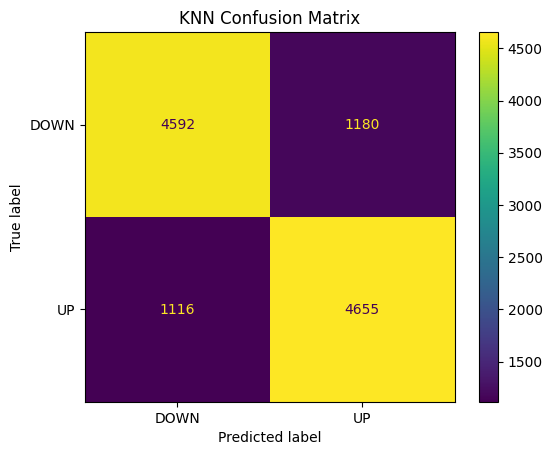


--- Running Unsupervised Learning: K-Means Clustering ---


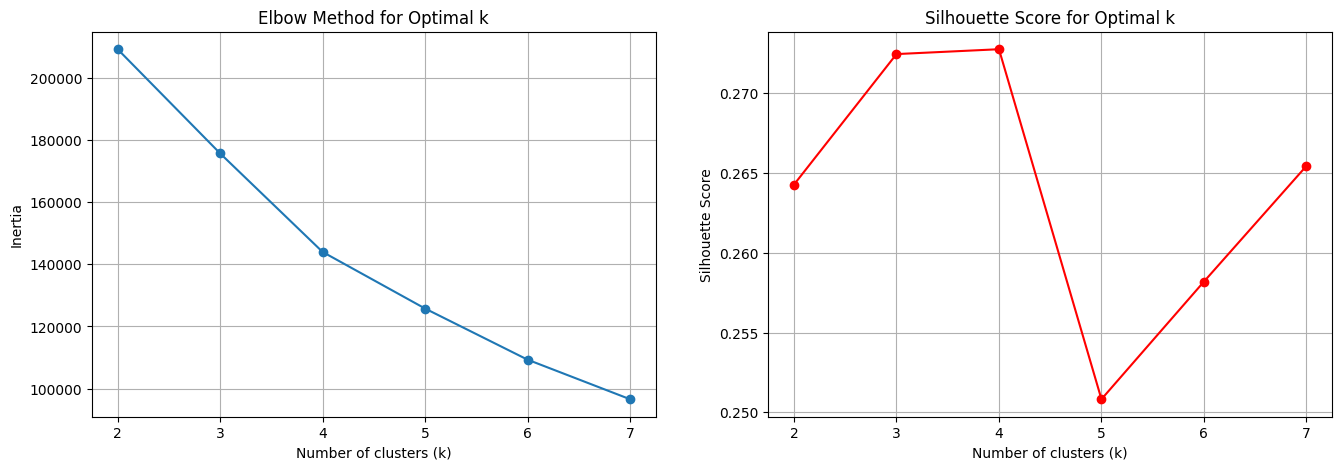

Chosen k based on best silhouette score: 4
Visualizing clusters using PCA...


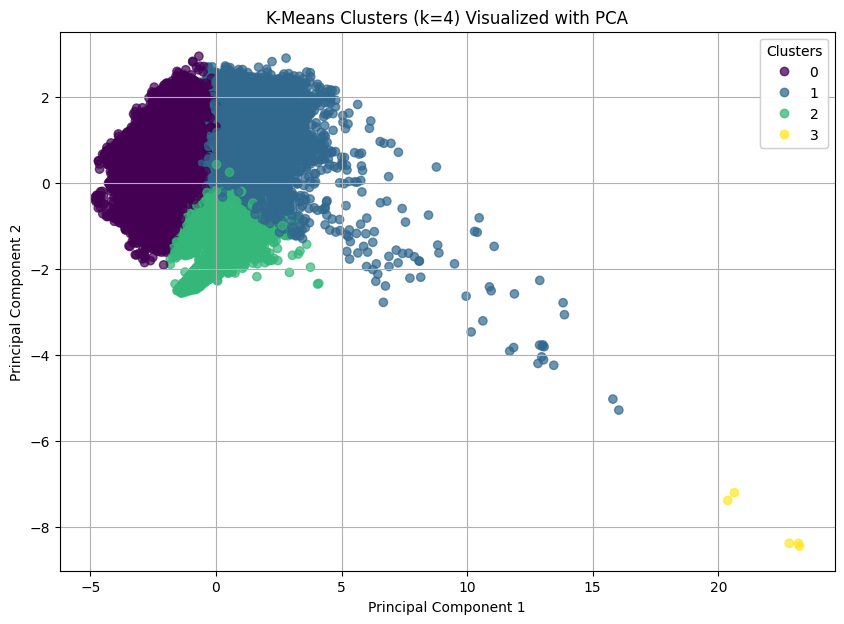

K-Means clustering finished in 126.55 seconds.

Total execution time: 138.20 seconds.


In [2]:
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def load_and_preprocess_data(data_id=45018):
    """
    Loads data from OpenML, cleans it, and prepares it for modeling.

    Args:
        data_id (int): The OpenML data_id for the dataset.

    Returns:
        tuple: A tuple containing the features (X) and the encoded target (y_encoded).
    """
    print(f"Fetching and preparing dataset {data_id}...")
    try:
        # Fetch data from OpenML
        electricity = fetch_openml(data_id=data_id, as_frame=True, parser='auto')
        df = electricity.frame
        
        # Preprocessing
        df.dropna(inplace=True)
        y = df['class']
        X = df.drop('class', axis=1)

        # Ensure all feature columns are numeric, dropping any that cannot be converted
        cols_to_drop = []
        for col in X.columns:
            if not pd.api.types.is_numeric_dtype(X[col]):
                try:
                    X[col] = pd.to_numeric(X[col])
                except ValueError:
                    cols_to_drop.append(col)
        X.drop(cols_to_drop, axis=1, inplace=True)
        
        # Encode target variable
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        print("Data loaded and preprocessed successfully.")
        return X, y_encoded, le.classes_
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None, None, None

def run_knn_classification(X, y):
    """
    Trains and evaluates a KNN classifier using GridSearchCV to find the best k.

    Args:
        X (pd.DataFrame): The feature matrix.
        y (np.array): The target vector.
    """
    print("\n--- Running Supervised Learning: KNN Classifier ---")
    start_time_knn = time.time()
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Create a pipeline that scales the data then applies KNN
    # This prevents data leakage from the test set into the scaler
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
    
    # Set up GridSearchCV to find the best number of neighbors
    param_grid = {'knn__n_neighbors': range(1, 21)} # Test k from 1 to 20
    grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best model and evaluate it
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    end_time_knn = time.time()
    
    # Print results
    print(f"KNN classification finished in {end_time_knn - start_time_knn:.2f} seconds.")
    print(f"Best K: {grid_search.best_params_['knn__n_neighbors']}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DOWN', 'UP'])
    disp.plot()
    plt.title('KNN Confusion Matrix')
    plt.show()

def perform_kmeans_clustering(X, target_names):
    """
    Performs K-Means clustering, finds the optimal k, and visualizes the results.

    Args:
        X (pd.DataFrame): The feature matrix.
        target_names (list): The original class names for labeling the plot.
    """
    print("\n--- Running Unsupervised Learning: K-Means Clustering ---")
    start_time_kmeans = time.time()
    
    # Scale the data as K-Means is distance-based
    scaler_cluster = StandardScaler()
    X_scaled = scaler_cluster.fit_transform(X)
    
    # Determine optimal k using Elbow and Silhouette methods
    inertia = []
    silhouette_scores = []
    k_range = range(2, 8)
    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_temp.fit(X_scaled)
        inertia.append(kmeans_temp.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))
    
    # Plot helper graphs to choose k
    fig_k, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ax1.plot(k_range, inertia, marker='o')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.grid(True)
    ax2.plot(k_range, silhouette_scores, marker='o', color='r')
    ax2.set_title('Silhouette Score for Optimal k')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.grid(True)
    plt.show()

    # Choose k based on the highest silhouette score
    chosen_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"Chosen k based on best silhouette score: {chosen_k}")
    
    # Run final K-Means model
    kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Use PCA to reduce dimensions for visualization
    print("Visualizing clusters using PCA...")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create a scatter plot of the clusters
    fig_pca, ax_pca = plt.subplots(figsize=(10, 7))
    scatter = ax_pca.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    ax_pca.set_title(f'K-Means Clusters (k={chosen_k}) Visualized with PCA')
    ax_pca.set_xlabel('Principal Component 1')
    ax_pca.set_ylabel('Principal Component 2')
    legend1 = ax_pca.legend(*scatter.legend_elements(), title="Clusters")
    ax_pca.add_artist(legend1)
    plt.grid(True)
    plt.show()

    end_time_kmeans = time.time()
    print(f"K-Means clustering finished in {end_time_kmeans - start_time_kmeans:.2f} seconds.")

# Main execution block
if __name__ == "__main__":
    start_time_total = time.time()
    
    X, y_encoded, class_names = load_and_preprocess_data(data_id=45018)
    
    if X is not None:
        # Run Supervised Learning Task
        run_knn_classification(X, y_encoded)
        
        # Run Unsupervised Learning Task
        perform_kmeans_clustering(X, class_names)
    
    end_time_total = time.time()
    print(f"\nTotal execution time: {end_time_total - start_time_total:.2f} seconds.")